In [21]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import seaborn as sns
import rasterio
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from rasterio.enums import Resampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [30]:
os.chdir(r'D:\Papers\Hesham Morgan')

In [31]:
data = pd.read_csv('GTP_Hammash_Area.csv')

In [32]:
data_new = data.loc[:, ~data.columns.isin(['Coordinate', 'DMS'])]

In [33]:
data_new

,Class,LS_B7,LS_B6,LS_B5,LS_B3,DEM,AS_B8,AS_B7,AS_B6,AS_B5,AS_B4
0,2,15737,16238,13853,11838,430,77,84,92,90,84
1,7,15363,20187,15436,12606,425,77,82,83,81,98
2,7,15850,21162,15607,12563,436,75,81,79,78,101
3,2,18634,19026,15580,12578,480,66,73,80,80,72
4,7,15791,20212,16026,12807,416,75,81,78,78,99
...,...,...,...,...,...,...,...,...,...,...,...
515,5,15144,16562,14022,11499,431,73,76,80,80,78
516,5,15144,16562,14022,11499,431,73,76,80,80,78
517,5,16230,17984,15883,12695,415,73,76,81,81,79
518,5,16230,17984,15883,12695,415,73,76,81,81,79


In [34]:
varia = data_new.drop('Class',axis=1)

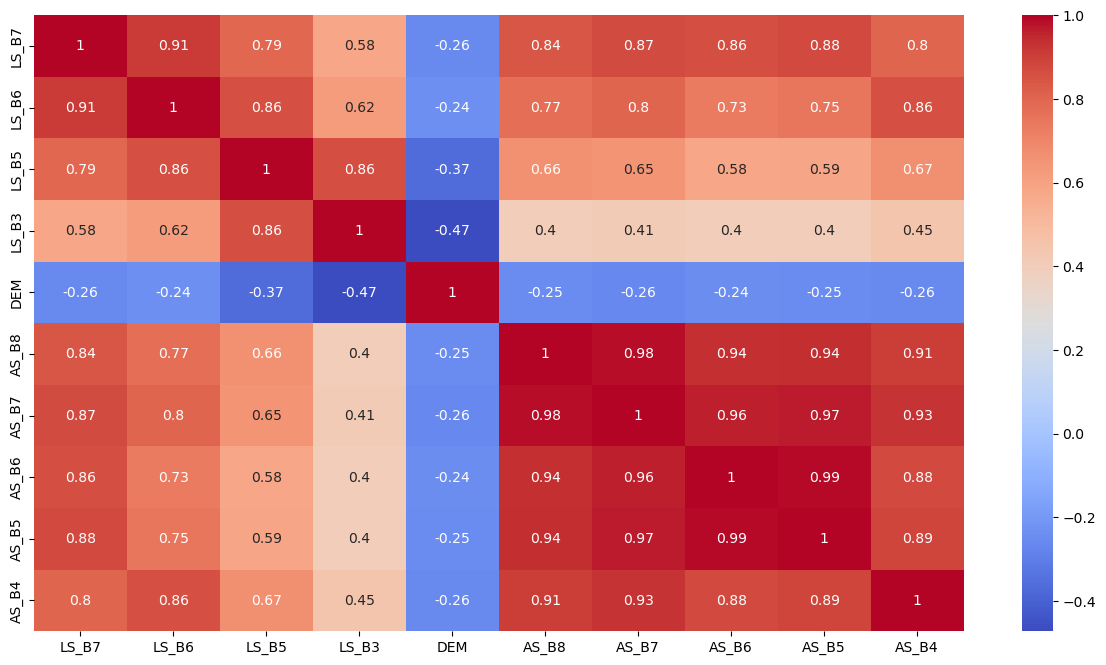

In [35]:
plt.figure(figsize=(15, 8))
sns.heatmap(varia.corr(), cmap='coolwarm', annot=True)
plt.show()

In [36]:
train = varia

In [37]:
test = pd.DataFrame(data_new['Class'])

In [38]:
test

,Class
0,2
1,7
2,7
3,2
4,7
...,...
515,5
516,5
517,5
518,5


In [39]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.1, random_state=30)

In [40]:
# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators=10000,      
    min_samples_leaf=1,      
    max_depth=81,            
    max_features=4,         
    oob_score=True,         
    random_state=30,         
    bootstrap=True           
)

# Fit the model to the training data
rfc.fit(X_train, y_train)

# Compute the OOB error
oob_error = 1 - rfc.oob_score_
print(f"OOB Error: {oob_error}")

# Predict on the test set
y_pred = rfc.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

C:\Users\maharjan\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


OOB Error: 0.19444444444444442
Accuracy: 0.9038461538461539
Precision: 0.9113247863247863
Recall: 0.9038461538461539
F1 Score: 0.9000933706816061
Confusion Matrix:
[[ 6  0  0  0  0  0  0  0]
 [ 1  5  0  0  2  0  0  0]
 [ 0  0  5  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0]
 [ 0  0  0  0 16  0  0  0]
 [ 0  1  0  0  0  4  0  0]
 [ 1  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  3]]


In [41]:
def extract_number(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    return -1  # Default if no number is found

directory_path = r'D:\Papers\Hesham Morgan\New_Hemash'
raster_files = [f for f in os.listdir(directory_path) if f.endswith('.tif')]

# Sort files numerically based on the first number found in each filename
raster_files = sorted(raster_files, key=extract_number)

raster_data = {}

# Read each raster file and store its data
for i, filename in enumerate(raster_files, start=1):
    with rasterio.open(os.path.join(directory_path, filename)) as src:
        data = src.read(1)  # Read the first band
        no_data_value = src.nodata

        # Set no data values to np.nan
        if no_data_value is not None:
            data = np.where(data == no_data_value, np.nan, data)

        raster_data[f'a{i}'] = data

In [42]:
# Assuming raster_data['a2'] contains your data
# Just to see if all nan values are discarded.
max_value = np.nanmin(raster_data['a9'])
print(f"The maximum value, ignoring NaNs, is: {max_value}")

The maximum value, ignoring NaNs, is: 53.0


In [43]:
# Step 1: Stack the rasters
# Assuming each raster in raster_data has the same dimensions
stack_shape = (len(raster_data),) + raster_data['a1'].shape
raster_stack = np.empty(stack_shape, dtype=np.float32)

for i in range(stack_shape[0]):
    raster_stack[i, :, :] = raster_data[f'a{i+1}']

# Step 2: Identify valid locations (no np.nan across the stack)
valid_mask = ~np.isnan(raster_stack).any(axis=0)

# Step 3: Prepare for prediction
# Flatten the stack and mask to create feature vectors only for valid locations
valid_features = raster_stack[:, valid_mask].T  # Transpose to have shape (n_samples, n_features)

# Predict only for valid locations
valid_predictions = rfc.predict(valid_features)

C:\Users\maharjan\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [44]:
valid_predictions

array([4, 4, 1, ..., 8, 8, 5], dtype=int64)

In [45]:
# Assuming valid_predictions is a numpy array
# Just to see the uniue values in the new prediction
unique_predictions = np.unique(valid_predictions)
print("Unique predictions:", unique_predictions)

Unique predictions: [1 2 3 4 5 6 7 8]


In [46]:
directory_path = r'D:\Papers\Hesham Morgan\New_Hemash'
raster_files = [f for f in sorted(os.listdir(directory_path)) if f.endswith('.tif')]

# Open the first raster file to get its shape
first_raster_file = os.path.join(directory_path, raster_files[0])
with rasterio.open(first_raster_file) as src0:
    out_shape = (src0.height, src0.width)

print("Shape of the first raster file:", out_shape)

Shape of the first raster file: (192, 254)


In [47]:
output_raster = np.full((src0.height, src0.width), np.nan, dtype=np.float32)

# Step 2: Fill in the predictions in the output array at valid locations
output_raster[valid_mask] = valid_predictions

# Step 3: Save the output array as a TIFF file
output_path = os.path.join(directory_path, 'valid_predictions.tif')
meta = src0.meta.copy()  # Copy metadata from an existing raster
meta.update(dtype=rasterio.float32, count=1)  # Ensure the metadata matches the output raster

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(output_raster, 1)

In [51]:
import shap
explainer = shap.TreeExplainer(rfc)

In [52]:
shap_values = explainer(X_train)

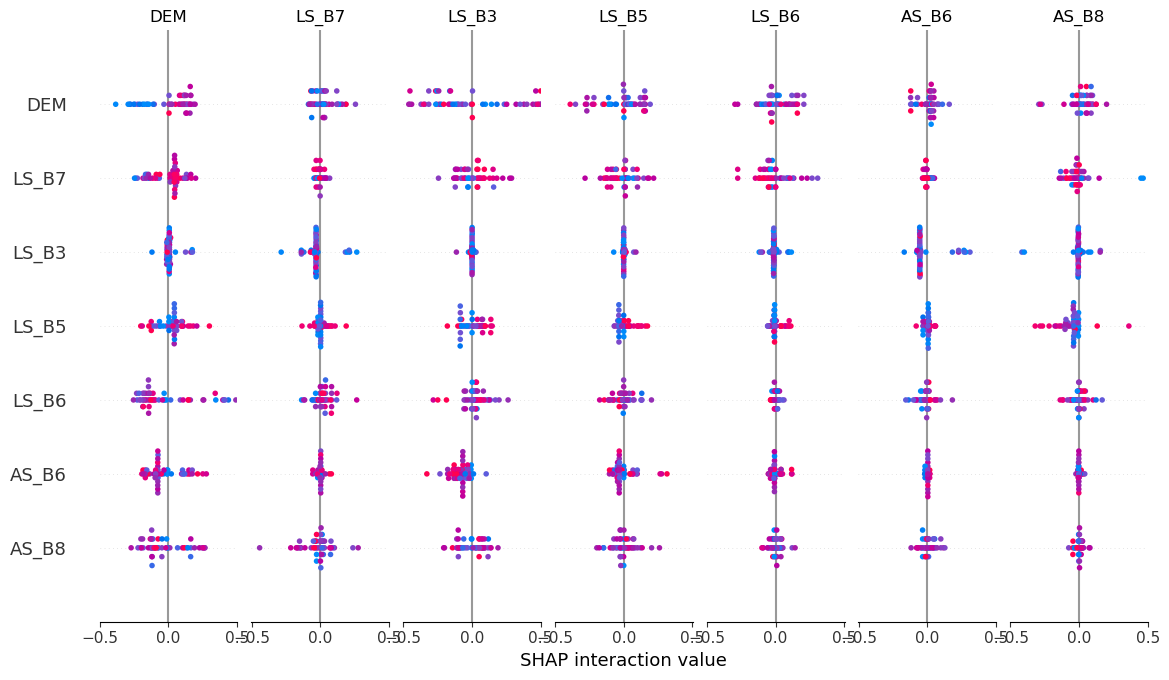

In [53]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test,approximate=True)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [54]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

In [55]:
mean_abs_shap_values

array([[0.01915384, 0.0220168 , 0.01427584, 0.03158549, 0.03055883,
        0.03513371, 0.01832897, 0.0071422 ],
       [0.04124573, 0.01384777, 0.01455556, 0.01366057, 0.04147812,
        0.0163212 , 0.02216039, 0.01316907],
       [0.0380456 , 0.02490271, 0.04208019, 0.00380683, 0.05884824,
        0.02951343, 0.01982153, 0.02948656],
       [0.04356387, 0.03061282, 0.03351618, 0.00634962, 0.12809431,
        0.04009204, 0.02186517, 0.06830099],
       [0.06453329, 0.09321775, 0.03900241, 0.02901798, 0.13604452,
        0.06503694, 0.01518665, 0.0555435 ],
       [0.02825255, 0.01694501, 0.05709571, 0.01591759, 0.03253852,
        0.01683795, 0.0171137 , 0.00363303],
       [0.01647168, 0.00613732, 0.01475236, 0.02694382, 0.02364785,
        0.00850249, 0.0073066 , 0.00410218],
       [0.00752503, 0.01768013, 0.00837799, 0.0422096 , 0.02356005,
        0.0175844 , 0.01593802, 0.00716697],
       [0.00992982, 0.02431824, 0.01327821, 0.07268885, 0.03309384,
        0.02297526, 0.018925

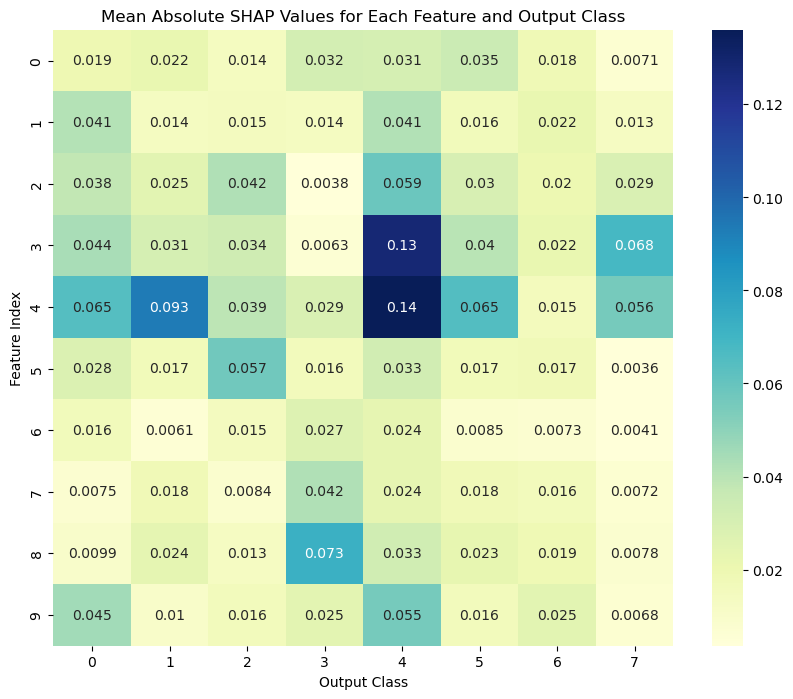

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mean_abs_shap_values, annot=True, cmap="YlGnBu")
plt.xlabel("Output Class")
plt.ylabel("Feature Index")
plt.title("Mean Absolute SHAP Values for Each Feature and Output Class")
plt.show()

In [57]:
shap_values

array([[[-8.44175726e-04, -6.03555720e-02, -1.57075019e-02, ...,
          1.38103268e-01, -1.48088794e-03, -1.39197671e-02],
        [-1.11502760e-04,  1.11532006e-03, -5.89861329e-03, ...,
          7.11376761e-02, -4.88923643e-02, -1.87118079e-02],
        [-4.63430203e-02, -5.61273996e-02,  1.51404063e-02, ...,
          1.29926870e-01,  7.31307920e-03, -2.18872558e-02],
        ...,
        [ 6.51190537e-04, -4.51000562e-02, -3.87876045e-04, ...,
          5.80615408e-02,  7.42516982e-03, -6.93669815e-04],
        [-9.87764809e-03, -5.98934907e-02,  1.36713598e-03, ...,
          6.95292264e-02,  2.92039857e-02,  2.81326708e-03],
        [-9.55119253e-03,  9.51094048e-03,  1.80673489e-03, ...,
          2.92580507e-02, -3.72962777e-02,  1.71237666e-03]],

       [[ 4.96388200e-03,  4.12904900e-02, -2.98042611e-03, ...,
          2.85575087e-03, -9.72387269e-03, -1.03286233e-02],
        [ 2.25291885e-02, -7.33722565e-03, -6.01997496e-03, ...,
          2.31737247e-02, -1.62938703e

100%|===================| 415/416 [04:27<00:00]        

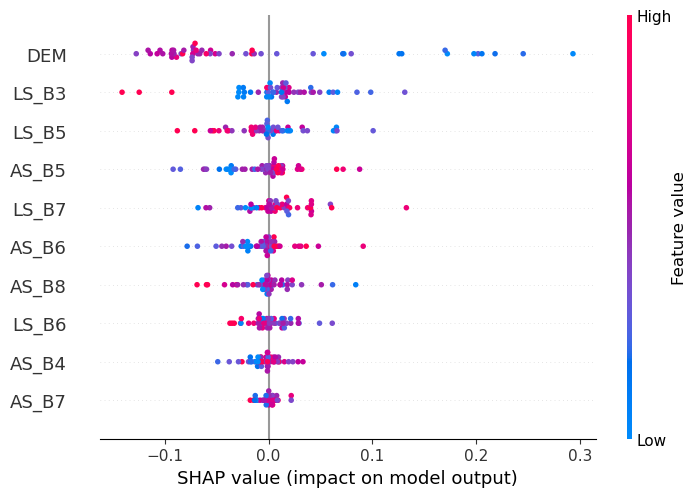

In [58]:
# Import SHAP if not already done
import shap

# Assuming `shap_values` is your 3D array of SHAP values and `X_test` is your test dataset
# Selecting SHAP values for class 1 as an example (use the correct index for your class of interest)
shap_values_class = shap_values[:, :, 1]  # This selects all samples and features for class 1

# Creating an Explanation object for the selected class SHAP values
# This requires your original data (X_test) and the base value for the class if available
explainer = shap.Explainer(rfc, X_test)
shap_values_explanation = explainer(X_test)
shap_values_explanation.values = shap_values_class
shap_values_explanation.base_values = shap_values_explanation.base_values[:, 1]  # Adjust base_values if necessary

# Now, using the beeswarm plot for the selected class
shap.plots.beeswarm(shap_values_explanation)

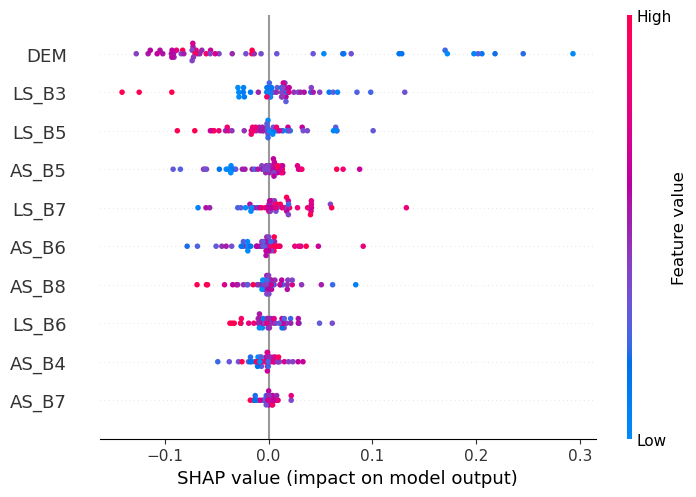

In [59]:
shap.plots.beeswarm(shap_values_explanation)

In [66]:
X_train

,LS_B7,LS_B6,LS_B5,LS_B3,DEM,AS_B8,AS_B7,AS_B6,AS_B5,AS_B4
67,16978,17437,14391,11818,434,85,91,97,94,88
87,19159,20507,18185,13959,410,106,107,106,105,109
92,18661,19136,16426,12921,427,79,86,93,89,80
468,15515,17409,16405,13457,398,74,76,79,78,78
126,15745,16158,14008,12204,398,70,78,82,82,76
...,...,...,...,...,...,...,...,...,...,...
430,15204,17130,14050,11303,440,77,83,87,84,86
145,17295,19034,15842,12355,430,92,95,93,94,94
140,19175,20804,17957,13385,418,91,94,93,92,91
500,15614,16966,15427,12430,400,73,74,76,74,73
